In [1]:
import json
import numpy as np
import random
import sys
from tqdm import tqdm
import re
from pathlib import Path

import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer

from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
import en_core_web_sm
nlp = en_core_web_sm.load()

from IPython.display import clear_output
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
%matplotlib inline

#############################################################
from utils import get_triplets_by_idd, get_description_name
from datasets import load_rubq, load_simple_questions, combined_dataset_non_stochastic
from models import EncoderBERT, get_projection_module_simple, get_tokenizer
from reject import reject_by_metric
from train import train_ensemble
from eval_models import eval_ensemble
from get_props import presearch_sq, presearch_rubq

%load_ext autoreload
%autoreload 1

2022-08-12 18:09:33.850005: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-12 18:09:33.854421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-12 18:09:33.854445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(m

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


### Loading Graph Embeddings and Questions

In [3]:
#path to full list of embeddings and full list of ids (one2one correspondence with embeddings)
PATH_TO_EMBEDDINGS_Q = "../new_data/entitie_embeddings_ru.json" 
PATH_TO_IDS = "../new_data/entitie_ids_ru_filtered.json"
PATH_TO_EMBEDDINGS_P = "../new_data/entitie_P_embeddings_ru.json" 

graph_embeddings_Q = json.load(open(PATH_TO_EMBEDDINGS_Q))
graph_embeddings_P = json.load(open(PATH_TO_EMBEDDINGS_P))

In [4]:
%autoreload

MASTER_SEED = 42

questions_train, relations_train, entities_train, answers_train, questions_val, relations_val, entities_val, answers_val, questions_test, answers_test = load_rubq(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)
simple_questions_train, simple_questions_val = load_simple_questions(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)

/notebook/meker/KBQA/datasets.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_train = np.array(answers)[train_ids]
/notebook/meker/KBQA/datasets.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_val = np.array(answers)[val_ids]


308
296
1186
16414


100% 16414/16414 [00:00<00:00, 212814.59it/s]

8327


### Dataset and Dataloaders

In [5]:
%autoreload

train_dataset = combined_dataset_non_stochastic(questions_train, answers_train, entities_train, relations_train, graph_embeddings_Q, graph_embeddings_P, simple_questions_train, device)
val_dataset = combined_dataset_non_stochastic(questions_val, answers_val, entities_val, relations_val, graph_embeddings_Q, graph_embeddings_P, simple_questions_val, device)

val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=64, shuffle=False)

In [6]:
embeddings_Q = graph_embeddings_Q
ids_list = list(graph_embeddings_Q.keys())
embeddings_Q = [embeddings_Q[Q] for Q in ids_list]
embeddings_tensor_Q = torch.FloatTensor(embeddings_Q)

embeddings_P = graph_embeddings_P
embeddings_P = [embeddings_P[P] for P in graph_embeddings_P.keys()]
embeddings_tensor_P = torch.FloatTensor(embeddings_P)

candidates = list(np.load("./data/presearched_fixed_rubq_test.npy", allow_pickle=True))

### Training loop

In [7]:
loss = nn.CosineEmbeddingLoss()
loss_name = str(loss)[:-2]
proj_hidden_size = 512

models_path = Path(f'./models/{loss_name}_{proj_hidden_size}_deterministic_rubq_stochastic_answers/')
models_path.mkdir(parents=True, exist_ok=True)

In [8]:
%autoreload

N_EPOCHS = 30
N_MODELS = 5

sq_val_cands = np.load('data/presearched_fixed_sq_val.npy', allow_pickle=True)
rubq_val_cands = np.load('data/presearched_fixed_rubq_val.npy', allow_pickle=True)
val_cands = list(rubq_val_cands) + list(sq_val_cands)

questions_val = list(questions_val)
answers_val = list(answers_val)

for e, p, a, q in tqdm(simple_questions_val):
    questions_val.append(q)
    answers_val.append([a])
    
questions_val = np.array(questions_val)
answers_val = np.array(answers_val)

100% 1000/1000 [00:00<00:00, 250495.94it/s]
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
# %autoreload

# train_ensemble(N_MODELS, N_EPOCHS, proj_hidden_size, train_dataset, val_dataloader, models_path, device, loss, val_cands, questions_val, answers_val, graph_embeddings_P, graph_embeddings_Q)

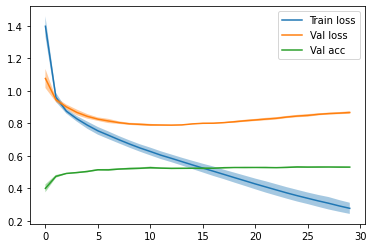

In [10]:
train_losses = []
val_losses = []
val_accs = []

for i in range(N_MODELS):
    train_losses.append(np.load(models_path / f'train_loss_{i}.npy'))
    val_losses.append(np.load(models_path / f'val_loss_{i}.npy'))
    val_accs.append(np.load(models_path / f'val_acc_{i}.npy'))

mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)

mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

mean_val_acc = np.mean(val_accs, axis=0)
std_val_acc = np.std(val_accs, axis=0)

plt.plot(list(range(N_EPOCHS)), mean_train_loss, label='Train loss')
plt.fill_between(list(range(N_EPOCHS)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.4)
plt.plot(list(range(N_EPOCHS)), mean_val_loss, label='Val loss')
plt.fill_between(list(range(N_EPOCHS)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.4)
plt.plot(list(range(N_EPOCHS)), mean_val_acc, label='Val acc')
plt.fill_between(list(range(N_EPOCHS)), mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.4)

plt.legend()
plt.show()

## Eval

In [11]:
import pickle

entities = np.load('data/candidate_entities_sq_test.npy', allow_pickle=True)

with open('data/entity_subgraphs_sq_test.pickle', 'rb') as handle:
    entity_subgraphs = pickle.load(handle)

In [12]:
sq_candidates = []

for question_entities in entities:
    candidates_dict = {}
    for entity in list(question_entities.item()):
        candidates_dict[entity] = entity_subgraphs[entity]
    sq_candidates.append(candidates_dict)

In [13]:
simple_questions_test = np.load("../new_data/simple_questions_test.npy")

simple_questions_filtered = []
questions_sq = []
answers_sq = []

for e, p, a, q in tqdm(simple_questions_test):
    if e in graph_embeddings_Q and a in graph_embeddings_Q and p in graph_embeddings_P:
        simple_questions_filtered.append((e, p, a, q))
        questions_sq.append(q)
        answers_sq.append([a])

100% 4751/4751 [00:00<00:00, 224741.32it/s]


### RuBQ

#### Best acc models

In [14]:
%autoreload

N_MODELS=5
proj_hidden_size = 512

models = []
for i in range(N_MODELS):
    encoder = EncoderBERT(device)
    projection_E = get_projection_module_simple(device, proj_hidden_size)
    projection_Q = get_projection_module_simple(device, proj_hidden_size)
    projection_P = get_projection_module_simple(device, proj_hidden_size)

    encoder.load_state_dict(torch.load(models_path / f'encoder_{i}_best_acc.pt'))
    projection_E.load_state_dict(torch.load(models_path / f'projection_E_{i}_best_acc.pt'))
    projection_Q.load_state_dict(torch.load(models_path / f'projection_Q_{i}_best_acc.pt'))
    projection_P.load_state_dict(torch.load(models_path / f'projection_P_{i}_best_acc.pt'))
    models.append({'encoder': encoder, 'projection_P': projection_P, 'projection_Q': projection_Q, 'projection_E': projection_E})
    
_, _, a_predicts, _, _, _, _, _, _, _, _, _, _, _, _, val_acc, _, _, _, _, _, a_model_predicts = eval_ensemble(questions_val, answers_val, graph_embeddings_P, graph_embeddings_Q, val_cands, models, device)

models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_val, a_model_predicts, a_predicts)):
    corr_models = 0
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
    if corr_models > 2 and (ensemble_preds[0] not in answers):
        print(i)
    
val_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
weights = val_model_accs

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dens

Accuracy:  0.5423076923076923
987


In [15]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, ensembling_mode='average', weights=weights)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [01:05, 18.11it/s]

Accuracy:  0.4662731871838111


#### Ind model accuracy

In [16]:
models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_test, a_model_predicts, a_predicts)):
    corr_models = 0
    if len(models_preds) == 0:
        for model_corrects in models_corrects:
            model_corrects.append(0.0)
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
rubq_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
mean_acc = np.mean(rubq_model_accs)
std_acc = np.std(rubq_model_accs)

print(rubq_model_accs)
print(round(max(rubq_model_accs), 3))
print(round(min(rubq_model_accs), 3))
print(round(mean_acc, 3))
print(round(std_acc, 3)) 

[0.4688026981450253, 0.45868465430016864, 0.448566610455312, 0.42495784148397975, 0.4494097807757167]
0.469
0.425
0.45
0.015


### SQ

In [17]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, ensembling_mode='average', weights=weights)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [02:29, 16.29it/s]

Accuracy:  0.5319934372436423


#### Ind model accuracy

In [18]:
models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_sq, a_model_predicts, a_predicts)):
    if len(models_preds) == 0:
        for model_corrects in models_corrects:
            model_corrects.append(0.0)
            
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
sq_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
mean_acc = np.mean(sq_model_accs)
std_acc = np.std(sq_model_accs)

print(sq_model_accs)
print(round(max(sq_model_accs), 3))
print(round(min(sq_model_accs), 3))
print(round(mean_acc, 3))
print(round(std_acc, 3))

[0.5196882690730107, 0.5254306808859721, 0.5213289581624282, 0.5262510254306809, 0.5311730926989335]
0.531
0.52
0.525
0.004


#### Epoch 30

In [19]:
%autoreload

N_MODELS=5
proj_hidden_size = 512

models = []
for i in range(N_MODELS):
    encoder = EncoderBERT(device)
    projection_E = get_projection_module_simple(device, proj_hidden_size)
    projection_Q = get_projection_module_simple(device, proj_hidden_size)
    projection_P = get_projection_module_simple(device, proj_hidden_size)

    encoder.load_state_dict(torch.load(models_path / f'encoder_{i}_30.pt'))
    projection_E.load_state_dict(torch.load(models_path / f'projection_E_{i}_30.pt'))
    projection_Q.load_state_dict(torch.load(models_path / f'projection_Q_{i}_30.pt'))
    projection_P.load_state_dict(torch.load(models_path / f'projection_P_{i}_30.pt'))
    models.append({'encoder': encoder, 'projection_P': projection_P, 'projection_Q': projection_Q, 'projection_E': projection_E})
    
_, _, a_predicts, _, _, _, _, _, _, _, _, _, _, _, _, val_acc, _, _, _, _, _, a_model_predicts = eval_ensemble(questions_val, answers_val, graph_embeddings_P, graph_embeddings_Q, val_cands, models, device)

models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_val, a_model_predicts, a_predicts)):
    corr_models = 0
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
    if corr_models > 2 and (ensemble_preds[0] not in answers):
        print(i)
    
val_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
weights = val_model_accs

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dens

Accuracy:  0.5346153846153846
157
889
1015


In [20]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, ensembling_mode='average', weights=weights)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1186it [01:06, 17.82it/s]

Accuracy:  0.46964586846543


#### Ind model accuracy

In [21]:
models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_test, a_model_predicts, a_predicts)):
    corr_models = 0
    if len(models_preds) == 0:
        for model_corrects in models_corrects:
            model_corrects.append(0.0)
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
rubq_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
mean_acc = np.mean(rubq_model_accs)
std_acc = np.std(rubq_model_accs)

print(rubq_model_accs)
print(round(max(rubq_model_accs), 3))
print(round(min(rubq_model_accs), 3))
print(round(mean_acc, 3))
print(round(std_acc, 3))

[0.4612141652613828, 0.45952782462057334, 0.4662731871838111, 0.46037099494097805, 0.4536256323777403]
0.466
0.454
0.46
0.004


### SQ

In [22]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, ensembling_mode='average', weights=weights)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2438it [02:29, 16.35it/s]

Accuracy:  0.5307629204265791


#### Ind model accuracy

In [23]:
models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_sq, a_model_predicts, a_predicts)):
    if len(models_preds) == 0:
        for model_corrects in models_corrects:
            model_corrects.append(0.0)
            
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
sq_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
mean_acc = np.mean(sq_model_accs)
std_acc = np.std(sq_model_accs)

print(sq_model_accs)
print(round(max(sq_model_accs), 3))
print(round(min(sq_model_accs), 3))
print(round(mean_acc, 3))
print(round(std_acc, 3))

[0.5229696472518458, 0.5254306808859721, 0.5291222313371616, 0.5205086136177195, 0.5246103363412633]
0.529
0.521
0.525
0.003
